Logistic regression es similar a linear regression, pero en lugar de predecir una salida continua, clasifica ejemplos de entrenamiento en un conjunto de categorías o etiquetas. Por ejemplo, una regresión lineal sobre un conjunto de datos sociales y económicos podría utilizarse para predecir el ingreso de una persona, pero la regresión logística podría usarse para predecir si esa persona estaba casada, tenía hijos o había sido arrestada alguna vez. En un sentido básico, la regresión logística solo responde preguntas que tienen respuestas sí/no, o preguntas que pueden contestarse con un 1 o un 0. Sin embargo, puede extenderse fácilmente a problemas donde existe un conjunto más amplio de categorías.

Aquí estoy usando el conjunto de datos Wine del UCI. Este mapea trece variables continuas que representan contenidos químicos de un vino a tres etiquetas, cada una correspondiente a una bodega diferente en Italia.

# Cargando y Graficando Datos

Inicialmente, solo estoy usando dos características del conjunto de datos: alcohol y ash (ceniza). Las etiquetas se proporcionan como un arreglo de datos con valores de 1 a 3, pero al inicio solo quiero un problema simple de regresión con respuesta sí o no.

Para lograr esto, primero filtro el conjunto de datos, reduciéndolo para incluir únicamente vinos con etiquetas 1 o 2. Luego uso la función label_binarize de scikit-learn, la cual toma una lista de longitud m con n valores posibles (dos en este caso) y la convierte en una matriz de m × n, donde cada columna representa una etiqueta con un valor de 1 y las demás con un valor de 0. Elijo la primera columna, aunque la segunda sería igualmente válida aquí, solo que con las etiquetas invertidas.

He incluido un pequeño ejemplo de label_binarize a continuación, barajando primero todo el conjunto de datos de entrada (los ejemplos están ordenados por bodega) y luego seleccionando los primeros diez.

In [8]:
# Importa la librería pandas para manejo de datos en tablas
import pandas as pd

# Importa NumPy para operaciones numéricas y manejo de arreglos
import numpy as np

# Importa label_binarize para convertir etiquetas a formato binario
from sklearn.preprocessing import label_binarize

# Carga el archivo data.txt en un DataFrame
data = pd.read_csv('data.txt')

# Filtra solo las filas donde la clase es 1 o 2
reduced = data[data['class'] <= 2]

# Selecciona las columnas alcohol y ash como matriz de características
# X = reduced.as_matrix(columns=['alcohol', 'ash'])
X = reduced[['alcohol', 'ash']].values

# Convierte las clases 1 y 2 en valores binarios (1 vs 2)
y = label_binarize(reduced['class'].values, classes=[1, 2])[:,0]

# Copia las etiquetas originales para generar un ejemplo aleatorio
example = np.copy(data['class'].values)

# Mezcla aleatoriamente los valores de las clases
np.random.shuffle(example)

# Selecciona los primeros 10 valores mezclados
example = example[0:10]

# Imprime los valores originales mezclados
print('original:', example)

# Convierte las etiquetas seleccionadas a formato binario según las clases presentes
example = label_binarize(example, classes=list(set(example)))

# Imprime la matriz binaria resultante
print('binarized:', example)

# Imprime la primera columna (1 vs todo lo demás)
print('1s vs all:', example[:,0])

original: [2 2 3 2 2 3 1 2 2 1]
binarized: [[0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]]
1s vs all: [0 0 0 0 0 0 1 0 0 1]


También divido los datos en conjuntos de entrenamiento y prueba antes de continuar. Una manera sencilla de hacerlo es con la función train_test_split de scikit-learn, que me permite especificar un porcentaje (aquí 25%) para tomar una muestra aleatoria del conjunto de datos y separarla para pruebas.

In [9]:
# Importa train_test_split para dividir los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Divide X y y en conjuntos de entrenamiento (75%) y prueba (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Imprime cuántos ejemplos quedaron en cada conjunto
print('train:', len(X_train), 'test:', len(X_test))


train: 97 test: 33


Porque voy a generar muchas gráficas de datos, defino una función que recibe un arreglo de puntos de datos $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` para variar el símbolo y el color de cada punto. Esta función admite tres etiquetas distintas, lo cual es suficiente para este conjunto de datos.

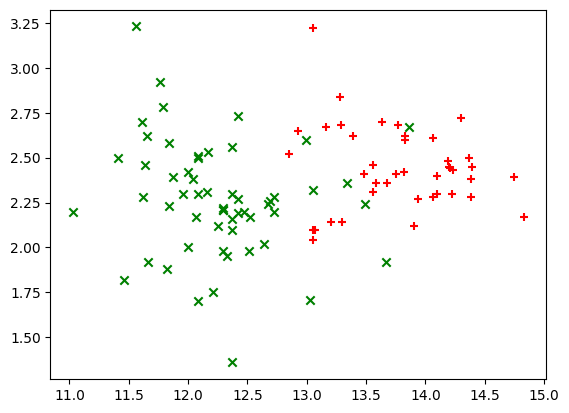

In [10]:
# Importa la librería para crear gráficos
import matplotlib.pyplot as plt

# Indica que las gráficas se mostrarán dentro del notebook
%matplotlib inline

# Define los marcadores que se usarán para cada clase de puntos
MARKERS = ['+', 'x', '.']

# Define los colores asociados a cada clase de puntos
COLORS = ['red', 'green', 'blue']

# Define una función para graficar puntos según sus etiquetas
def plot_points(xy, labels):
    
    # Recorre cada etiqueta única encontrada en labels
    for i, label in enumerate(set(labels)):
        
        # Selecciona únicamente los puntos cuya etiqueta coincide
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        
        # Selecciona el marcador correspondiente según el índice
        marker = MARKERS[i % len(MARKERS)]
        
        # Selecciona el color correspondiente según el índice
        color = COLORS[i % len(COLORS)]
        
        # Grafica los puntos para esa etiqueta
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

# Llama a la función para graficar los puntos del conjunto de entrenamiento
plot_points(X_train, y_train)


Hay una zona bastante evidente cerca del centro del gráfico donde una línea podría dividir los dos colores de puntos con una pequeña cantidad de error.

# Regresión Logística Simple

Para implementar regresión logística, necesito una función de hipótesis h_theta(x), una función de costo J(theta), y una función de gradiente que calcule las derivadas parciales de J(theta).

En la regresión logística, h_theta es la función sigmoide. La función sigmoide está acotada entre 0 y 1 y produce un valor que puede interpretarse como una probabilidad. Este valor también puede representar una respuesta sí/no con una frontera de decisión en 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Usar el mean squared error de la regresión lineal no es una buena idea aquí, porque la función de costo resultante no es convexa y por lo tanto no es adecuada para el descenso de gradiente. En su lugar, la diferencia h_theta(x^i) - y^i se calcula de manera distinta para y = 0 y y = 1, y el resultado se transforma logarítmicamente en una función convexa:

J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{i}\log(h_\theta(x^{i})) + (1 - y^{i})\log(1 - h_\theta(x^{i})) \right]

Afortunadamente, la derivada de esta función es exactamente la misma que en la regresión lineal, solo que con un h_theta(x) diferente:

\frac{\partial}{\partial \theta_{j}} J(\theta) = \sum_{i=1}^{m} (h_\theta(x^{i}) - y^{i}) x^{i}_{j}

In [ ]:
# Importa NumPy para operaciones matemáticas y manejo de arreglos
import numpy as np

# Define la función sigmoide, utilizada como función de hipótesis en regresión logística
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# Define la función de costo para regresión logística
def cost(theta, X, y):
    theta = theta[:,None]   # Convierte theta en un vector columna
    y = y[:,None]           # Convierte y en un vector columna
    
    hyp = sigmoid(X.dot(theta))        # Calcula las hipótesis h(x) = sigmoid(X·theta)
    pos = np.multiply(-y, np.log(hyp)) # Parte del costo para los casos donde y = 1
    neg = np.multiply((1 - y), np.log(1 - hyp))  # Parte del costo donde y = 0
    
    return np.sum(pos - neg) / (len(X))  # Devuelve el costo promedio total

# Define el gradiente de la función de costo (derivada parcial respecto a theta)
def gradient(theta, X, y):
    theta = theta[:,None]  # Convierte theta a vector columna
    y = y[:,None]          # Convierte y a vector columna
    
    error = sigmoid(X.dot(theta)) - y   # Calcula el error entre hipótesis y etiquetas reales
    return X.T.dot(error) / len(X)      # Devuelve el gradiente promedio


Es importante notar el tratamiento de y y theta arriba. En cada función, convierto explícitamente cada uno en un arreglo ndarray de tamaño n×1 o m×1, para que las operaciones matriciales funcionen correctamente. Una alternativa es usar un matrix de NumPy, que tiene reglas de álgebra lineal más estrictas y trata las matrices unidimensionales más como vectores columna. Sin embargo, encontré que era incómodo hacer que la interfaz de matrices funcionara correctamente tanto con la función de optimización usada abajo como con TensorFlow. La sintaxis de indexación puede verse como una forma explícita de convertir en columna el arreglo de parámetros o etiquetas.

En lugar de escribir manualmente un descenso de gradiente, uso un algoritmo de optimización de Scipy llamado fmin_tnc para realizarlo. Esta función toma como parámetros la función de costo, un conjunto inicial de valores para θ, la función de gradiente y una tupla con los argumentos que se le pasan a cada una. Defino una función train que antepone una columna de 1s a los datos de entrenamiento (permitiendo un parámetro de sesgo θ0), ejecuta la función de minimización y devuelve el primero de sus valores de retorno: los parámetros finales para θ.


theta y y se convierten en vectores columna a propósito.
Esto se debe a que, si no lo haces, NumPy puede interpretar mal las dimensiones y las multiplicaciones matriciales no funcionarían como deberían.

Se podría usar numpy.matrix, pero es incómodo.
Aunque parece más “matemático”, en la práctica causa problemas cuando mezclas código con Scipy o TensorFlow. Por eso prefieren convertir los arreglos manualmente con [:, None].

En vez de programar el descenso de gradiente a mano, usan fmin_tnc.
Scipy ya trae optimizadores que hacen el trabajo más rápido y robusto.

La función train agrega una columna de unos a X.
Esto sirve para incorporar el bias (el intercepto) dentro de la matriz sin tener que manejarlo por separado.

fmin_tnc devuelve los valores finales de theta.
Esos son los parámetros optimizados después de varias iteraciones.

In [11]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    # Inserta una columna de 1s al inicio de X para incluir el término de sesgo (theta_0)
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    
    # Inicializa theta como un vector de ceros con tantas posiciones como columnas tenga X
    theta = np.zeros(X.shape[1])
    
    # Ejecuta el optimizador fmin_tnc usando la función de costo, el gradiente y los datos
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    # Devuelve los valores finales optimizados de theta
    return result[0]

# Entrena el modelo usando los datos de entrenamiento
theta = train(X_train, y_train)

# Imprime los parámetros finales de theta
print('theta: ', theta)


theta:  [59.38524725 -4.08226634 -2.52560701]


  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   4.20598156E-01
    1    3  6.882814151315774E-01   1.40760110E-03
tnc: fscale = 26.6539
    2    5  6.304429772456569E-01   4.49567340E-02
    3    7  6.295117882402445E-01   4.44344813E-03
    4    9  6.227824616557683E-01   2.09258168E-03
    5   11  6.226949294591190E-01   4.48481310E-03
    6   13  5.855839895987509E-01   2.49969386E-02
    7   15  5.847775502291479E-01   7.62594266E-03
    8   17  5.726387117842022E-01   5.76489665E-03
    9   19  5.723605456432651E-01   8.21643020E-03
tnc: stepmx = 1000
   10   21  5.365847586026459E-01   1.19475710E-02
   11   23  5.358586356356949E-01   9.64482001E-03
   12   25  5.162363891002922E-01   4.21195036E-03
   13   27  5.158073830542483E-01   1.09183590E-02
   14   32  4.737015574126128E-01   1.02803928E-02
   15   34  4.729728433743136E-01   2.38777394E-03
   16   37  4.239456343816029E-01   3.82985333E-02
   17   39  4.226347188466601E-01   2.63322207E-03


#Decision Boundaries and Evaluation

Puedo evaluar los resultados de la optimización de forma visual y estadística, pero también necesito una función más: predict, que toma como entrada un arreglo de ejemplos X y los valores de parámetros aprendidos theta, y devuelve la etiqueta predicha para cada uno. Aquí también deben anteponerse 1s a las entradas, y devuelvo un valor entero que representa si el resultado de la función de hipótesis sigmoid es igual o mayor que 0.5.

Para probar los resultados de esas predicciones, Scikit-learn proporciona tres funciones para calcular accuracy, precision y recall (https://en.wikipedia.org/wiki/Precision_and_recall
). Los datos de prueba de antes se usan aquí, por lo que los resultados representan el rendimiento del clasificador en datos no vistos.

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    # Inserta una columna de 1s al inicio de X para incluir el término de sesgo (theta_0)
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    
    # Calcula la probabilidad usando la función sigmoide y convierte a 1 o 0 según el umbral 0.5
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

# Obtiene las predicciones para los datos de prueba
predictions = predict(X_test, theta)

# Convierte las predicciones de matriz a arreglo plano
predictions = np.asarray(predictions).flatten()

# Imprime métricas de evaluación del modelo
print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))


accuracy: 1.0
precision: 1.0
recall: 1.0


Es mucho más interesante revisar los resultados de manera visual, al menos mientras el número de características esté limitado a dos. Para hacer esto, necesito graficar nuevamente los puntos de entrada y luego superponer la frontera de decisión encima. Probé varios métodos para esto en Matplotlib, y descubrí que un gráfico de contorno sin relleno me dio los mejores resultados. Esto también se puede hacer calculando manualmente la función para graficar, o usando un gráfico de contorno relleno que sombreé las áreas reales, pero hacer las matemáticas a mano es tedioso, y los mapas de color de los contornos rellenos dejan mucho que desear visualmente.

A continuación, defino una función plot_boundary que toma una matriz n×2 de valores de características (x0, x1) y una función de predicción, luego construye una malla de puntos (x, y) correspondientes a los posibles valores de (x0, x1) dentro del rango de entrada. Después de ejecutar la función de predicción sobre todos ellos, el resultado es un punto (x, y, z) en el espacio. Como el resultado no es continuo y cambia directamente de 0 a 1, solo hay un contorno que puede dibujarse en la gráfica: la frontera de decisión.

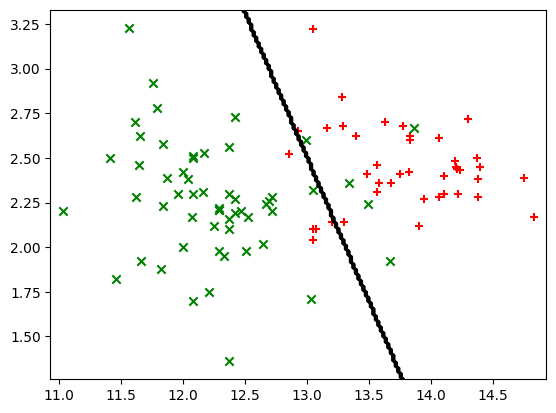

In [15]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    # Calcula los límites mínimo y máximo para el eje X (característica 0)
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    
    # Calcula los límites mínimo y máximo para el eje Y (característica 1)
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    # Crea una malla de puntos (xs, ys) dentro del rango definido
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    # Apila las coordenadas de la malla en pares (x0, x1)
    xys = np.column_stack([xs.ravel(), ys.ravel()])
    
    # Calcula las predicciones sobre toda la malla y las reacomoda al tamaño original
    zs = pred(xys).reshape(xs.shape)

    # Dibuja la línea de contorno donde cambia la predicción (la frontera de decisión)
    plt.contour(xs, ys, zs, colors='black')
        
# Grafica los puntos del conjunto de entrenamiento
plot_points(X_train, y_train)

# Grafica la frontera de decisión usando la función predict con los parámetros theta
plot_boundary(X_train, lambda x: predict(x, theta))


Este trabajo mostró, paso a paso, cómo funciona la regresión logística por dentro. Se construyó el modelo desde cero: se prepararon los datos, se creó la función que hace las predicciones, se entrenó el modelo y finalmente se evaluó cómo responde con nuevos datos. También se dibujó la línea que separa las dos clases para entender visualmente cómo decide el modelo.

En resumen, el ejercicio permitió comprender de forma práctica cómo un modelo puede aprender a clasificar datos y cómo evaluar si lo está haciendo bien. Es una base clara y útil para seguir aprendiendo sobre modelos más complejos en el futuro.